# IHDP Data

Import of all needed libraries, numpy, pandas, matplot, sckitlearn, some will be used further on. 

In [1]:
!pip install econml

     |████████████████████████████████| 3.3 MB 5.4 MB/s 
     |████████████████████████████████| 77 kB 6.0 MB/s 
     |████████████████████████████████| 123 kB 48.4 MB/s 
     |████████████████████████████████| 356 kB 35.1 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491669 sha256=79f9ff94295da8b3492e96cf39c1977e9c59e7bfaced86aa2fac15885efd1d88
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


In [2]:
!wget "https://github.com/dmachlanski/CE888_2022/blob/main/project/data/ihdp.npz?raw=true" -O "ihdp.npz"
!wget "https://raw.githubusercontent.com/PauMarquez99/DataScience-CE888/Assignment2/Assignments/CE888%20Assignment%202/Datasets%20Notebooks/CE888-Functions.py" -O "functions.py"

--2022-04-27 20:25:11--  https://github.com/dmachlanski/CE888_2022/blob/main/project/data/ihdp.npz?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/dmachlanski/CE888_2022/raw/main/project/data/ihdp.npz [following]
--2022-04-27 20:25:11--  https://github.com/dmachlanski/CE888_2022/raw/main/project/data/ihdp.npz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/project/data/ihdp.npz [following]
--2022-04-27 20:25:12--  https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/project/data/ihdp.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... con

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functions as f
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sns.set(font_scale=1.4)

Data import and structure checking, we are able to see that the characteristics "x", we have treatment "t", the outcome "yf" and counter "ycf" and the indivudial treatment effect "ite".

In [6]:
df = np.load('ihdp.npz')

df.files

['x', 't', 'yf', 'ycf', 'ite']

Check for missing values and the shape of the dataframe. There are the 29 columns, the 5 mentioned above, in which "x" is an array of 25x747, meaning there are 25 background variables. Each column contains 747 rows of data, including the labels. Also we noticed there are no missing values in any column.

In [7]:
for data in df.files:
  print(f'{data}: {df[data].shape, df[data].dtype}')

x: ((747, 25), dtype('float64'))
t: ((747, 1), dtype('float64'))
yf: ((747, 1), dtype('float64'))
ycf: ((747, 1), dtype('float64'))
ite: ((747, 1), dtype('float64'))


As we can see our background features "x" are divided in 25 columns, which will be merged for a better analysis when visualizing the data. There is also noticeable that this dataset contains the outcome factuals and counterfactuals, which tells us it has simulated outcomes (since it is not common to have both, as we can not go back in time). And instead of the effect, we are given the _Individual Treatment Effect_.

In [8]:
X = df['x']
T = df['t'].reshape(-1, 1)
Yf = df['yf'].reshape(-1, 1)
Ycf = df['ycf'].reshape(-1, 1)
ite = df['ite']

To have a better understandment of the behaviour of the data, we will plot it's histograms.

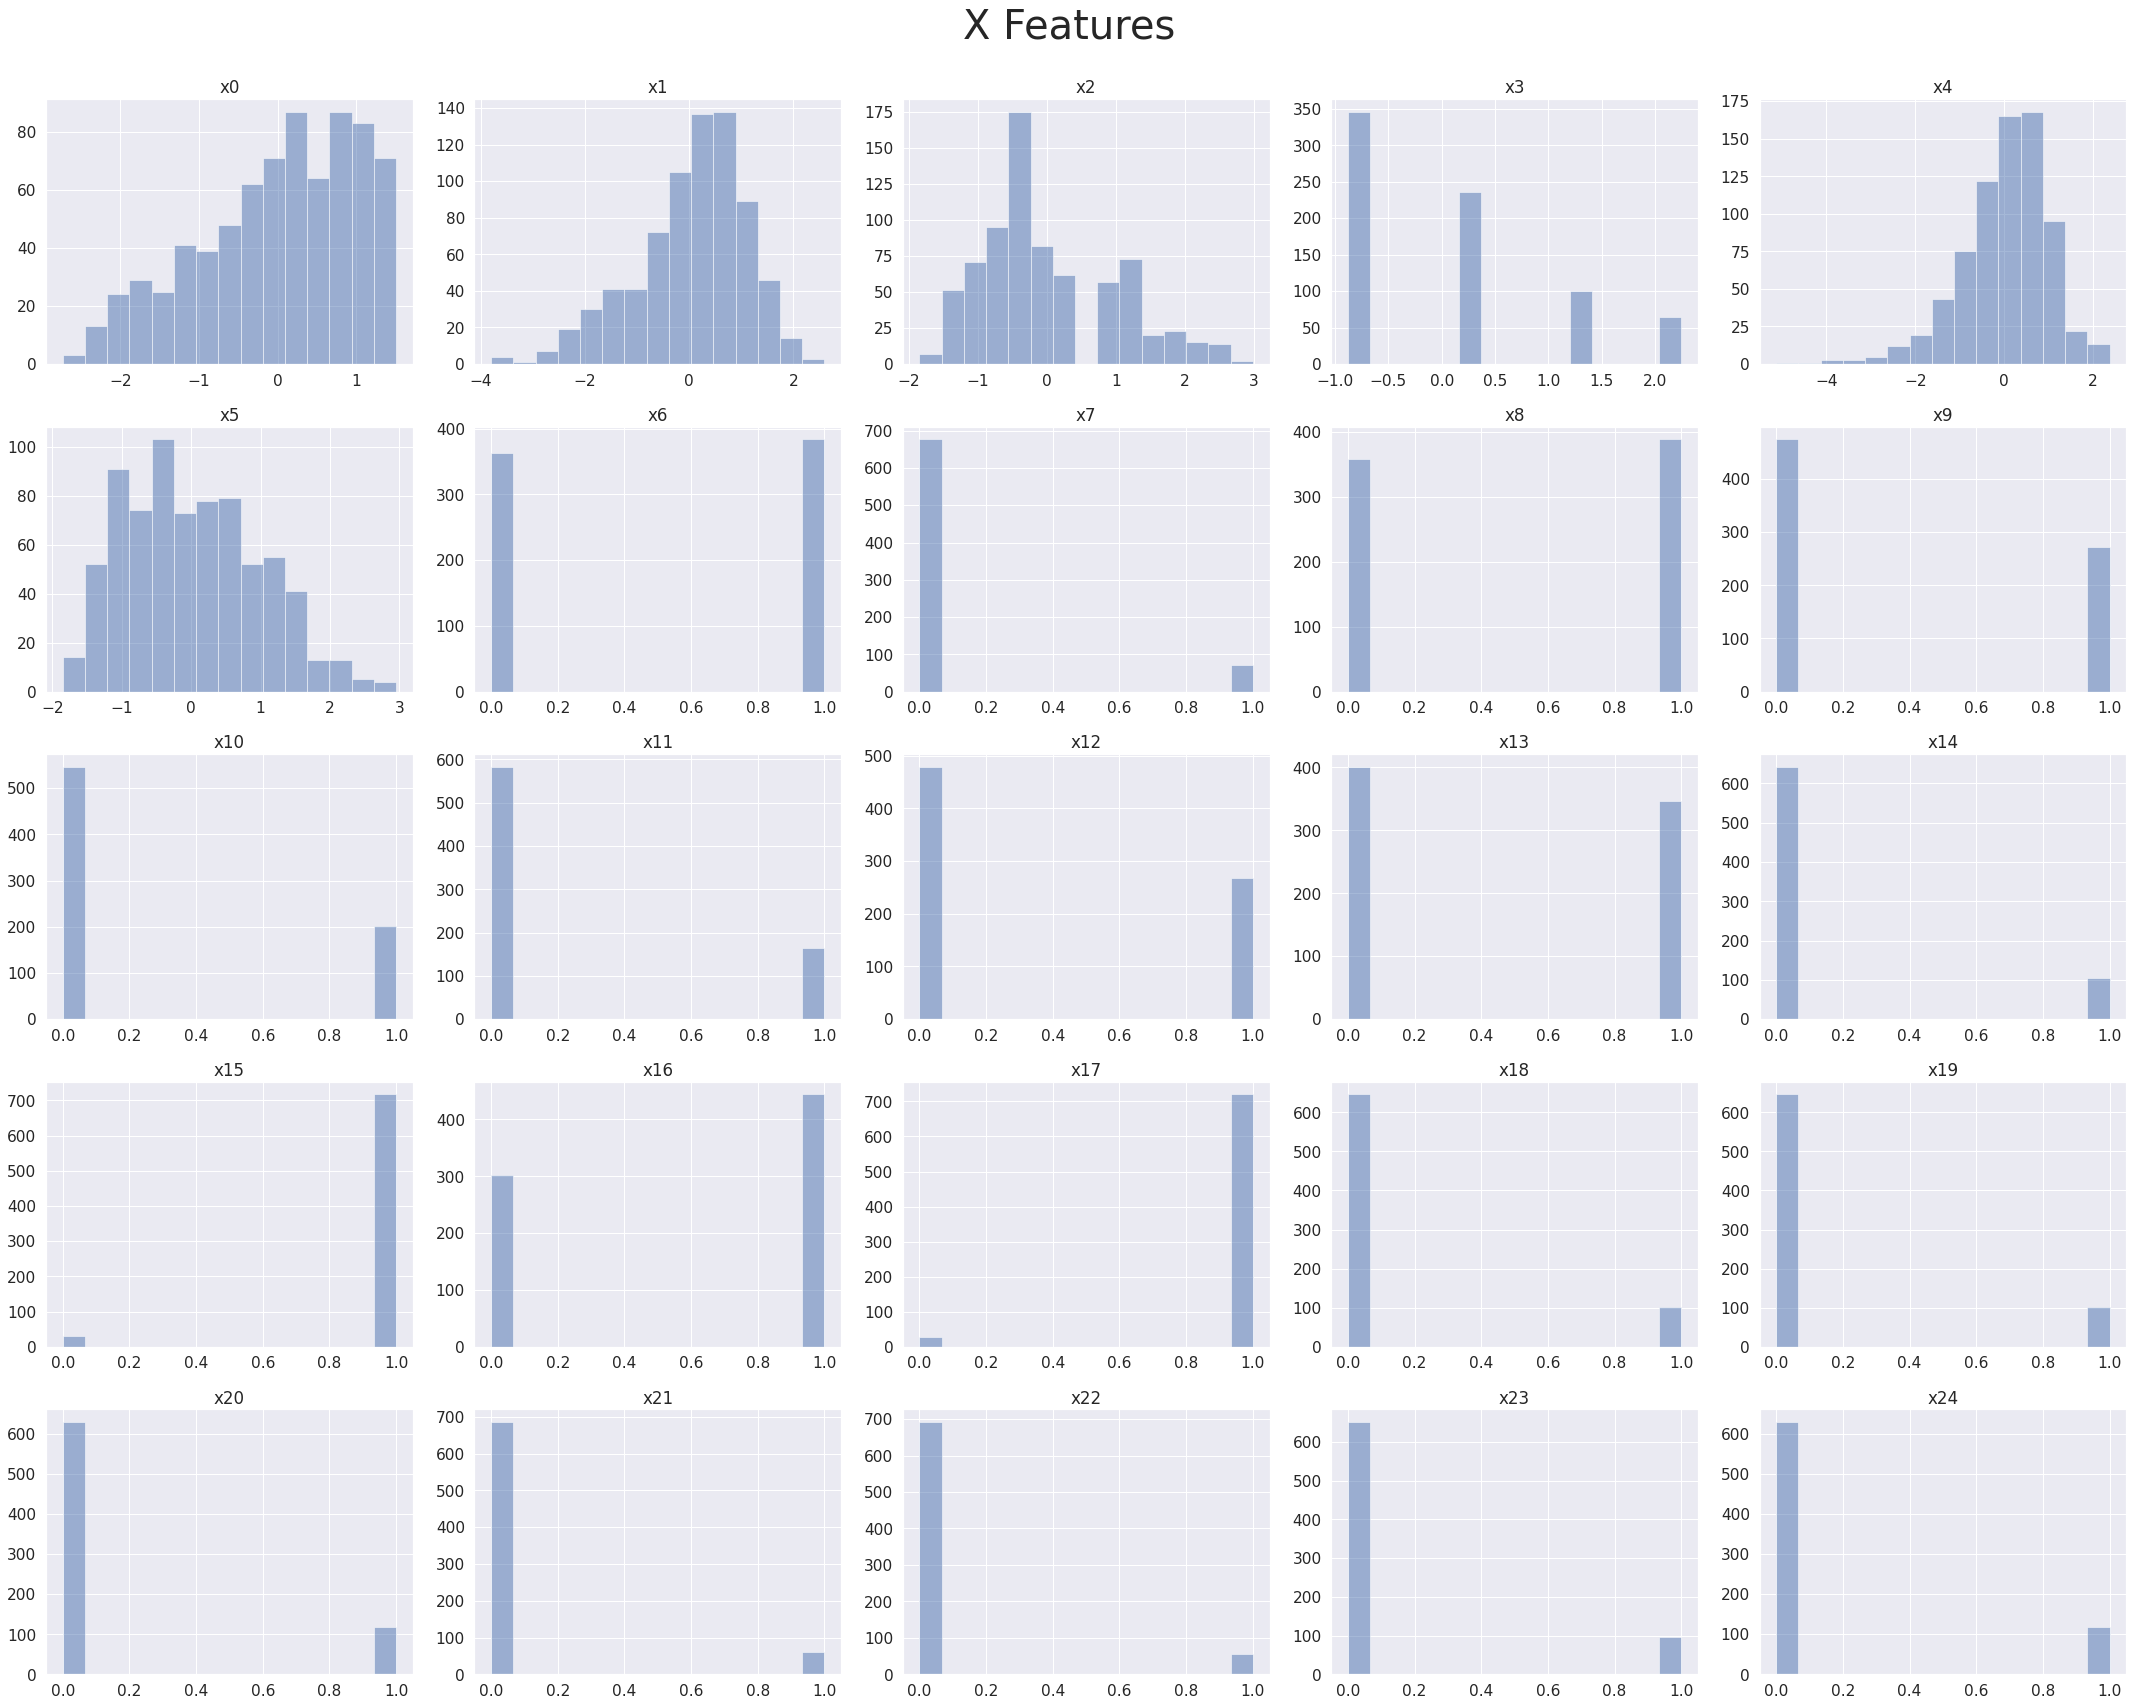

In [9]:
xName = ["x0", "x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9", "x10", "x11", "x12", "x13", "x14", "x15", "x16", "x17", "x18", "x19", "x20", "x21", "x22", "x23", "x24"]
Xp = pd.DataFrame(data=X)
Xp.columns = xName

axes = Xp.hist(color='b', alpha=0.5, bins=15, figsize=(30,25), layout=(5, 5))
plt.suptitle("X Features", size=40)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("ihdp_xFeatures.pdf", dpi=1500)



The histograms of the _X_ features were displayed in an individual manner for the exploration of their type per column, this as the file loaded was a npz file that has all the _X_ features concatenated in a single 2-Dimensional array. This also allows us to view that throughout the 25 features we have 6 of them being continuous.

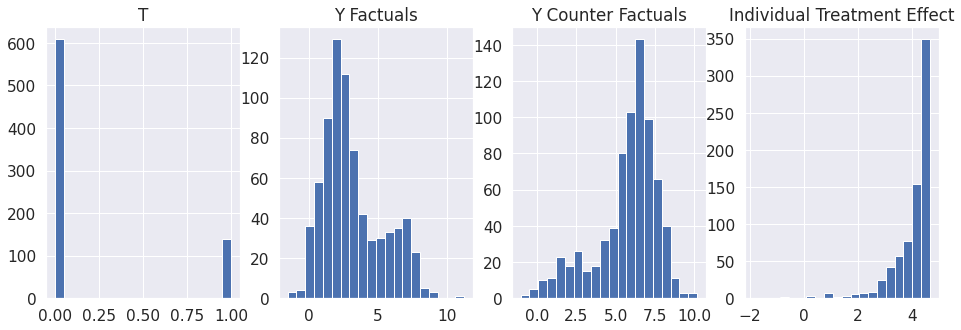

In [10]:
bins=20
fig, axs = plt.subplots(1, 4, figsize=(16, 5))
axs[0].hist(T, bins=bins)
axs[1].hist(Yf, bins=bins)
axs[2].hist(Ycf, bins=bins)
axs[3].hist(ite, bins=bins)
axs[0].title.set_text('T')
axs[1].title.set_text('Y Factuals')
axs[2].title.set_text('Y Counter Factuals')
axs[3].title.set_text('Individual Treatment Effect')
sns.set()
plt.show()
fig.savefig("ihdp_TreatmentAndElse.pdf", dpi=1200)

In [11]:
print("Amount of 0 in T: ", np.count_nonzero(df['t'] == 0))
print("Amount of 1 in T: ", np.count_nonzero(df['t'] == 1))

Amount of 0 in T:  608
Amount of 1 in T:  139


As seen above one of the first things that come to mind are the difference in T.  Having a count of values we are able to see that the data for treatment is not balanced, having **81.39 %** _not treated_ and the remaining **18.61 %** _is_.

While the *ITE* is clearly skewed to the left, as *Ycf* is and therefore expecting that *Yf* skewes to the right.

In [12]:
np.mean(ite)

4.016066896118338

Due to the skewness of *ITE* we find that as expected the *ATE* is **4.016**.

## Preprocessing

In [13]:
x_train, x_rem, y_train, y_rem, t_train, t_rem, ite_train, ite_rem = train_test_split(X, Yf, T, ite, train_size=0.67)

In [14]:
x_valid, x_test, y_valid, y_test, t_valid, t_test, ite_valid, ite_test = train_test_split(x_rem, y_rem, t_rem, ite_rem, test_size=0.27)

In [15]:
scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(x_train)
x_valid = scaler_x.transform(x_valid)
x_test = scaler_x.transform(x_test)

## Training

### Random Forest Regressor

In [16]:
rf = RandomForestRegressor()

# Train on the training data.
rf.fit(np.concatenate([x_train, t_train], axis=1), y_train.flatten())

# Training predictions:
rf_y0_in = rf.predict(np.concatenate([x_train, np.zeros_like(t_train)], axis=1))
rf_y1_in = rf.predict(np.concatenate([x_train, np.ones_like(t_train)], axis=1))

# Validation predictions (model's generalisation to unseen examples):
rf_y0_out = rf.predict(np.concatenate([x_valid, np.zeros_like(t_valid)], axis=1))
rf_y1_out = rf.predict(np.concatenate([x_valid, np.ones_like(t_valid)], axis=1))

# Test predictions:
rf_y0_t = rf.predict(np.concatenate([x_test, np.zeros_like(t_test)], axis=1))
rf_y1_t = rf.predict(np.concatenate([x_test, np.ones_like(t_test)], axis=1))

# Compute ITEs (training and validation)
# ITE = Y_1 - Y_0
rf_te_in = rf_y1_in - rf_y0_in
rf_te_out = rf_y1_out - rf_y0_out
rf_te_t = rf_y1_t - rf_y0_t

### Linear Regression

In [30]:
lr = LinearRegression()

# Train on the training data.
lr.fit(np.concatenate([x_train, t_train], axis=1), y_train.flatten())

# Training predictions:
lr_y0_in = lr.predict(np.concatenate([x_train, np.zeros_like(t_train)], axis=1))
lr_y1_in = lr.predict(np.concatenate([x_train, np.ones_like(t_train)], axis=1))

# Validation predictions (model's generalisation to unseen examples):
lr_y0_out = lr.predict(np.concatenate([x_valid, np.zeros_like(t_valid)], axis=1))
lr_y1_out = lr.predict(np.concatenate([x_valid, np.ones_like(t_valid)], axis=1))

# Test predictions:
lr_y0_t = lr.predict(np.concatenate([x_test, np.zeros_like(t_test)], axis=1))
lr_y1_t = lr.predict(np.concatenate([x_test, np.ones_like(t_test)], axis=1))

# Compute ITEs
# ITE = Y_1 - Y_0
lr_te_in = lr_y1_in - lr_y0_in
lr_te_out = lr_y1_out - lr_y0_out
lr_te_t = lr_y1_t - lr_y0_t

## Evaluation

### Errors

In [45]:
# Error on ATE
true_ate = 4.016

rf_ate_t = f.abs_ate(ite_test, rf_te_t)
lr_ate_t = f.abs_ate(ite_test, lr_te_t)


# PEHE
rf_pehe_t = f.pehe(ite_test, rf_te_t)
lr_pehe_t = f.pehe(ite_test, lr_te_t)


In [46]:
results = []
results.append(['RF', rf_ate_t, rf_pehe_t])
results.append(['LR', lr_ate_t, lr_pehe_t])

cols = ['Method', 'ATE test', 'PEHE test']

df = pd.DataFrame(results, columns=cols)
df

,Method,ATE test,PEHE test
0,RF,0.014761,0.883179
1,LR,0.113088,0.530436


### Confidence Interval

In [36]:
rf_ate_bounds = f.mean_ci(rf_te_t)
lr_ate_bounds = f.mean_ci(lr_te_t)

results = []
results.append(['RF', rf_ate_bounds[0], rf_ate_bounds[1], rf_ate_bounds[2]])
results.append(['LR', lr_ate_bounds[0], lr_ate_bounds[1], lr_ate_bounds[2]])

cols = ['Method', 'ATE mean', 'CI lower', 'CI upper']

df = pd.DataFrame(results, columns=cols)
df

,Method,ATE mean,CI lower,CI upper
0,RF,4.211135,4.035418,4.386851
1,LR,4.083286,4.083286,4.083286
